In [62]:
import sys
sys.path.append("/home/chenlidong/polyAttn")
import numpy as np
import pandas as pd
from rdkit import Chem
# from utils import molecule2graph

In [63]:
element_names = ['*', 'C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br','I','H']

In [3]:
homopolymer_data = pd.read_csv("/home/chenlidong/polyAttn/data/homopolymer/homopolymer.csv")
copolymer_data = pd.read_csv("/home/chenlidong/polyAttn/data/copolymer/copolymer.csv")

In [4]:
Egc_data = pd.read_csv('/home/chenlidong/polymer-chemprop-master/data/polymer-chemprop-data-main/homopolymer/Egc.csv')

In [5]:
Exp96_data = pd.read_csv("/home/chenlidong/polymer-chemprop-master/data/polymer-chemprop-data-main/homopolymer/96_homopolymer_MD_Exper.csv")

In [5]:
def get_info_from_copolymer_format(copolymer_str):
    info = copolymer_str.split("|")
    return info

In [5]:
Egc_data.head()

,smiles,value,type,copolymer_type
0,[*]C[*],6.8972,0,0
1,[*]CC([*])C,6.5196,0,0
2,[*]CC([*])CC,6.5170,0,0
3,[*]CC([*])CCC,6.7336,0,0
4,[*]CC([*])CC(C)C,6.7394,0,0


# 下面的代码用于统计两个数据集里的元素组成

In [6]:
df = Egc_data
# df = copolymer_data
additional_set = set()
num = [0] * len(element_names)
atom_num = []
first_column = df.iloc[:, 0]
for index, row in first_column.iteritems():
    mol = Chem.MolFromSmiles(row)
    atom_elements = set([atom.GetSymbol() for atom in mol.GetAtoms()])
    atom_num.append(len(mol.GetAtoms()))

    for element in atom_elements:
        if element in element_names:
            index = element_names.index(element)
        else:
            index = len(element_names) - 1
            additional_set.add(element)
        num[index] += 1
print(additional_set)
print(num)
print(atom_num)

/tmp/ipykernel_197681/2073883479.py:7: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, row in first_column.iteritems():


set()
[3380, 3379, 1835, 2703, 691, 245, 23, 35, 138, 50, 5, 13]
[3, 5, 6, 7, 8, 8, 13, 7, 6, 4, 8, 12, 14, 10, 8, 6, 9, 9, 10, 9, 14, 11, 11, 16, 26, 20, 20, 17, 19, 19, 18, 11, 12, 12, 12, 12, 16, 14, 15, 12, 12, 12, 13, 20, 14, 10, 11, 11, 13, 18, 5, 6, 7, 17, 6, 10, 8, 9, 7, 12, 11, 8, 13, 13, 17, 7, 8, 6, 10, 13, 4, 7, 15, 11, 11, 12, 6, 8, 15, 14, 17, 14, 14, 17, 14, 20, 15, 13, 11, 10, 10, 9, 8, 12, 12, 13, 14, 9, 13, 13, 10, 7, 9, 10, 11, 21, 10, 12, 17, 18, 21, 30, 12, 19, 9, 10, 14, 14, 16, 18, 11, 13, 15, 17, 18, 11, 13, 14, 9, 10, 7, 12, 13, 10, 13, 11, 9, 13, 13, 13, 15, 17, 14, 15, 15, 11, 14, 12, 21, 9, 10, 14, 28, 15, 11, 10, 25, 14, 13, 12, 16, 11, 9, 5, 5, 6, 6, 7, 7, 9, 8, 5, 10, 10, 6, 14, 16, 9, 10, 9, 21, 15, 18, 12, 8, 14, 7, 7, 8, 8, 9, 8, 5, 8, 10, 18, 14, 8, 8, 7, 4, 5, 6, 6, 7, 8, 8, 10, 5, 6, 7, 9, 7, 7, 7, 7, 8, 7, 8, 9, 9, 9, 10, 10, 11, 11, 13, 11, 14, 14, 16, 7, 9, 6, 8, 10, 10, 7, 9, 11, 12, 13, 15, 12, 9, 9, 11, 13, 21, 16, 11, 13, 7, 9, 10, 11, 14, 15

In [7]:
np.mean(atom_num)

21.46153846153846

In [11]:
smiles_with_hydrogens = "[*]C([2H])=C([*])[2H]"
mol = Chem.MolFromSmiles(smiles_with_hydrogens)
mol_no_hydrogens = Chem.RemoveHs(mol)

smiles_without_hydrogens = Chem.MolToSmiles(mol_no_hydrogens)
smiles_without_hydrogens

'*C([2H])=C(*)[2H]'

In [15]:
mol = Chem.MolFromSmiles("[*]C([2H])=C([*])[2H]")
dir(mol.GetAtoms()[0])

['ClearProp',
 'DescribeQuery',
 'GetAtomMapNum',
 'GetAtomicNum',
 'GetBonds',
 'GetBoolProp',
 'GetChiralTag',
 'GetDegree',
 'GetDoubleProp',
 'GetExplicitBitVectProp',
 'GetExplicitValence',
 'GetFormalCharge',
 'GetHybridization',
 'GetIdx',
 'GetImplicitValence',
 'GetIntProp',
 'GetIsAromatic',
 'GetIsotope',
 'GetMass',
 'GetMonomerInfo',
 'GetNeighbors',
 'GetNoImplicit',
 'GetNumExplicitHs',
 'GetNumImplicitHs',
 'GetNumRadicalElectrons',
 'GetOwningMol',
 'GetPDBResidueInfo',
 'GetProp',
 'GetPropNames',
 'GetPropsAsDict',
 'GetQueryType',
 'GetSmarts',
 'GetSymbol',
 'GetTotalDegree',
 'GetTotalNumHs',
 'GetTotalValence',
 'GetUnsignedProp',
 'HasOwningMol',
 'HasProp',
 'HasQuery',
 'InvertChirality',
 'IsInRing',
 'IsInRingSize',
 'Match',
 'NeedsUpdatePropertyCache',
 'SetAtomMapNum',
 'SetAtomicNum',
 'SetBoolProp',
 'SetChiralTag',
 'SetDoubleProp',
 'SetExplicitBitVectProp',
 'SetFormalCharge',
 'SetHybridization',
 'SetIntProp',
 'SetIsAromatic',
 'SetIsotope',
 'Set

# 下面的代码是统计数据集里两个目标的平均数和误差

# 下面的代码是polygnn里的数据增强

In [25]:
def n_to_subtract(atoms_removed_inds, atom_ind):
    return int(np.argwhere(np.sort(atoms_removed_inds + [atom_ind]) == atom_ind)[0][0])

In [26]:
def bind_frags(
    m1,
    m1_tails,
    m2,
    m2_heads,
    m1_connectors,
    m2_connectors,
    bond_types,
):
    """
    Bind *mol* objects, m1 and m2, together with a bond of type 'bond_type' at connection points m1_tail and m2_head
    """

    combo_mol = Chem.rdmolops.CombineMols(m1, m2)
    em = Chem.EditableMol(combo_mol)
    removed_atoms = [np.inf]  # init with 'inf' so that n_to_subtract will be 0 to start
    for (m1_connector, m2_connector, m1_tail, m2_head, bond_type) in zip(
        m1_connectors, m2_connectors, m1_tails, m2_heads, bond_types
    ):
        em.AddBond(
            m1_connector - n_to_subtract(removed_atoms, m1_connector),
            m2_connector
            + m1.GetNumAtoms()
            - n_to_subtract(removed_atoms, m2_connector + m1.GetNumAtoms()),
            bond_type,
        )
        em.RemoveAtom(m1_tail - n_to_subtract(removed_atoms, m1_tail))
        removed_atoms.append(m1_tail)
        em.RemoveAtom(
            m2_head
            + m1.GetNumAtoms()
            - n_to_subtract(removed_atoms, m2_head + m1.GetNumAtoms())
        )
        removed_atoms.append(m2_head + m1.GetNumAtoms())

    new_mol = em.GetMol()
    try:
        Chem.SanitizeMol(new_mol)
        return new_mol
    except:
        print(f"!!! Binding failed for {Chem.MolToSmiles(combo_mol)} !!!")
        return None

In [27]:
def get_star_inds(mol):
    if type(mol) == str:
        mol = Chem.MolFromSmiles(mol)
    inds = tuple(mol.GetSubstructMatches(Chem.MolFromSmarts("[#0]~*")))
    inds = tuple(zip(*inds))
    if len(inds[0]) != 2:
        raise ValueError(
            "Invalid repeat unit. It is likely that at least one star contains more than one bond."
        )
    return list(inds[0]), list(inds[1])

In [33]:
class LinearPol(Chem.rdchem.Mol):
    """
    Linear Polymer class.

    Attributes:
        mol (Chem.rdchem.Mol): The RDKit molecule of the parent polymer.
        star_inds (list): List of star atom indices in the parent polymer. Sorted from smallest to largest index.
        connector_inds (list): List of connector atom indices in the parent polymer. Sorted from smallest to largest index.
        periodic_bond_type (Chem.rdchem.BondType): The bond type of the periodic bond in the parent polymer.
    """

    def __init__(self, mol):
        """
        Initializes the LinearPol object.

        Args:
            mol (str or Chem.rdchem.Mol): SMILES string or RDKit molecule of the parent polymer.
        """
        if isinstance(mol, str):
            self.SMILES = mol
            self.mol = Chem.MolFromSmiles(mol)
        else:
            self.mol = mol

        self.star_inds, self.connector_inds = get_star_inds(self.mol)
        self.periodic_bond_type = self.get_pbond_type()

    def get_pbond_type(self):
        """
        Returns the bond type of the periodic bond.

        Returns:
            Chem.rdchem.BondType: The bond type of the periodic bond.

        Raises:
            ValueError: If the bond types of the periodic bond are mismatching.
        """
        bond1_type = self.mol.GetBondBetweenAtoms(self.star_inds[0], self.connector_inds[0]).GetBondType()
        bond2_type = self.mol.GetBondBetweenAtoms(self.star_inds[1], self.connector_inds[1]).GetBondType()
        if bond1_type != bond2_type:
            raise ValueError("Invalid repeat unit. Periodic bond types are mismatching.")
        return bond1_type

    def multiply(self, n):
        """
        Return a LinearPol which is n times repeated from itself
        """
        add_lp = LinearPol(self.mol)
        for _ in range(n - 1):
            add_lp = LinearPol(
                bind_frags(
                    self.mol,
                    [self.star_inds[1]],
                    add_lp.mol,
                    [add_lp.star_inds[0]],
                    [self.connector_inds[1]],
                    [add_lp.connector_inds[0]],
                    [self.periodic_bond_type],
                )
            )
        return add_lp

In [37]:
lp = LinearPol("[*]Oc1ccc(-c2ccc(C([*])=O)cc2)cc1")
pm = lp.multiply(3).mol
Chem.MolToSmiles(pm)

'*Oc1ccc(-c2ccc(C(=O)Oc3ccc(-c4ccc(C(=O)Oc5ccc(-c6ccc(C(*)=O)cc6)cc5)cc4)cc3)cc2)cc1'

# 下面的代码是测试概率边

In [142]:
smiles_list = copolymer_data.iloc[0:5,:].SMILES.to_list()

In [145]:
graph = molecule2graph.mol2graph(smiles_list)

In [149]:
graph.get_components()[-2]

[(1, 42), (43, 54), (97, 54), (151, 42), (193, 54)]

# 以下代码用于测试4w数据集里最多有多少个原子

In [91]:
monomer0_path = "/home/chenlidong/polymer-chemprop-master/data/polymer-chemprop-data-main/homopolymer/Egc_aug.csv"
monomer1_path = "/home/chenlidong/polymer-chemprop-master/data/polymer-chemprop-data-main/homopolymer/Egc.csv"

In [92]:
monomer_0 = pd.read_csv(monomer0_path)
monomer_1 = pd.read_csv(monomer1_path)

In [96]:
smiles_list = monomer_0.iloc[:,0].to_list()

In [94]:
smiles_list = monomer_1.iloc[:,0].to_list()

In [97]:
max_num = 0
for smiles in smiles_list:
    mol = Chem.MolFromSmiles(smiles)
    num_atoms = mol.GetNumAtoms()
    if num_atoms == 22:
        print(smiles)
    max_num = max(max_num,num_atoms)
print(max_num)

OB(O)c1cc2ccc3cc(B(O)O)cc4ccc(c1)c2c34
22


In [ ]:
"Brc1c2ccccc2c(-c2c3ccccc3c(Br)c3ccccc23)c2ccccc12"
"OB(O)c1cc2ccc3cc(B(O)O)cc4ccc(c1)c2c34"

# 以下代码为统计数据分布

In [2]:
from glob import glob
import pandas as pd
import numpy as np
path = "/home/chenlidong/polymer-chemprop-master/data/polymer-chemprop-data-main/results/vipea/cv9-monomer/polymer"
a = glob(f'{path}/input_test_?.csv')

In [4]:
all_path = "/home/chenlidong/polymer-chemprop-master/data/polymer-chemprop-data-main/results/vipea/cv9-monomer/master/dataset-master_chemprop.csv"
df = pd.read_csv(all_path)

In [8]:
df.head()

,master_chemprop_input,EA vs SHE (eV),IP vs SHE (eV),type,copolymer_type
0,OB(O)c1cc(F)c(B(O)O)cc1F.Oc1cc(O)c(Br)c(O)c1Br,-3.406210,1.808017,0,0
1,OB(O)c1cc(F)c(B(O)O)cc1F.Oc1cc(O)c(Br)c(O)c1Br,-2.991909,1.761062,0,1
2,OB(O)c1cc(F)c(B(O)O)cc1F.Oc1cc(O)c(Br)c(O)c1Br,-3.196570,1.817267,0,2
3,OB(O)c1cc(F)c(B(O)O)cc1F.N#Cc1cc(Br)c(F)cc1Br,-2.472685,2.635116,0,0
4,OB(O)c1cc(F)c(B(O)O)cc1F.N#Cc1cc(Br)c(F)cc1Br,-2.469582,2.608899,0,1


In [6]:
np.mean(df.iloc[:,1])

-2.541360351065899

In [7]:
np.mean(df.iloc[:,2])

1.4534074661951963

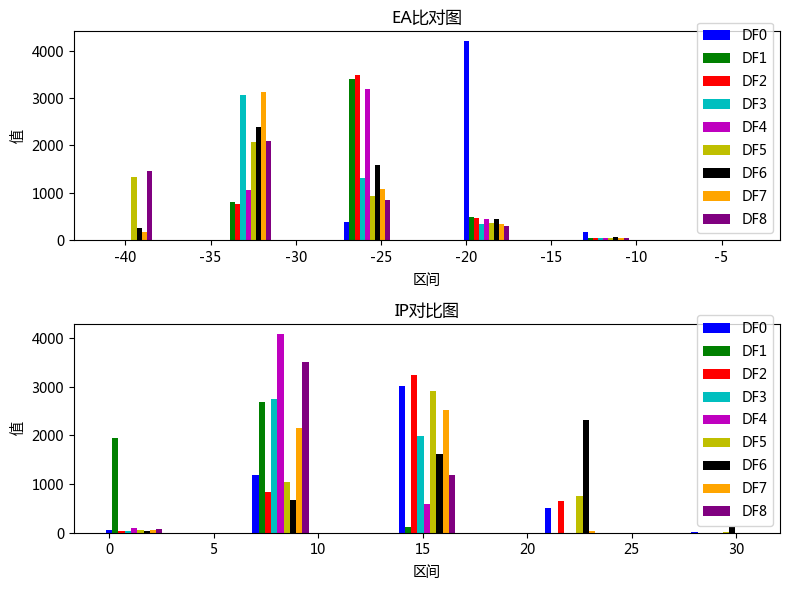

In [62]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.rcParams["font.sans-serif"] = ["Microsoft YaHei"]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 创建一个画布，分成两个子图
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# 创建一个颜色列表，用于区分不同的DataFrame
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple']

# 设置柱状图的间隔和宽度
interval = 7  # 间隔
width = 0.3  # 柱的宽度

# 绘制第一个图，比对 "列1" 的数据
for i, df in enumerate(a):
    data = pd.read_csv(df)['EA vs SHE (eV)'] * 10
    bins = range(-41, 6, interval)
    hist, edges = np.histogram(data, bins=bins)
    x = [edge + width * i for edge in edges[:-1]]
    ax1.bar(x, hist, width=width, label=f'DF{i}', color=colors[i])

ax1.set_xlabel('区间')
ax1.set_ylabel('值')
ax1.set_title('EA比对图')
ax1.legend()

# 绘制第二个图，比对 "列2" 的数据
for i, df in enumerate(a):
    data = pd.read_csv(df)['IP vs SHE (eV)'] * 10
    bins = range(0, 39, interval)
    hist, edges = np.histogram(data, bins=bins)
    x = [edge + width * i for edge in edges[:-1]]
    ax2.bar(x, hist, width=width, label=f'DF{i}', color=colors[i])

ax2.set_xlabel('区间')
ax2.set_ylabel('值')
ax2.set_title('IP对比图')
ax2.legend()

# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()


# 以下代码为给将cv9里面的数据进行正确的修正

In [81]:
df = pd.read_csv("/home/chenlidong/polymer-chemprop-master/data/polymer-chemprop-data-main/results/vipea/cv9-monomer/master/dataset-master_chemprop_origin.csv")

In [82]:
df.head()

,master_chemprop_input,EA vs SHE (eV),IP vs SHE (eV),type
0,Fc1ccc(F)cc1.Oc1cc(O)cc(O)c1,-3.406210,1.808017,0
1,Fc1ccc(F)cc1.Oc1cc(O)cc(O)c1,-2.991909,1.761062,0
2,Fc1ccc(F)cc1.Oc1cc(O)cc(O)c1,-3.196570,1.817267,0
3,Fc1ccc(F)cc1.N#Cc1ccc(F)cc1,-2.472685,2.635116,0
4,Fc1ccc(F)cc1.N#Cc1ccc(F)cc1,-2.469582,2.608899,0


将单体表示进行修正

In [83]:
a = pd.read_csv("/home/chenlidong/polymer-chemprop-master/data/polymer-chemprop-data-main/datasets/vipea/acids.csv")
b = pd.read_csv("/home/chenlidong/polymer-chemprop-master/data/polymer-chemprop-data-main/datasets/vipea/bromides.csv")

In [84]:
str(a.iloc[1,0])

'OB(O)c1cc2ccc3cc(B(O)O)cc4ccc(c1)c2c34'

In [85]:
idx1 = 9*682*3
idx2 = 9*682*5
for i in range(len(df)):
    if i<idx1:
        df.iloc[i,0] = f"{str(a.iloc[i//(682*3),0])}.{str(b.iloc[i%(682*3)//3,0])}"
    elif i<idx2:
        df.iloc[i,0] = f"{str(a.iloc[(i-idx1)//(682*2),0])}.{str(b.iloc[(i-idx1)%(682*2)//2,0])}"
    else:
        df.iloc[i,0] = f"{str(a.iloc[(i-idx2)//(682*2),0])}.{str(b.iloc[(i-idx2)%(682*2)//2,0])}"

In [86]:
df.tail()

,master_chemprop_input,EA vs SHE (eV),IP vs SHE (eV),type
42961,O=S1(=O)c2cc(B(O)O)ccc2-c2ccc(B(O)O)cc21.O=[N+...,-1.366831,2.531914,2
42962,O=S1(=O)c2cc(B(O)O)ccc2-c2ccc(B(O)O)cc21.CC(Oc...,-2.784383,1.455677,2
42963,O=S1(=O)c2cc(B(O)O)ccc2-c2ccc(B(O)O)cc21.CC(Oc...,-2.861863,1.523136,2
42964,O=S1(=O)c2cc(B(O)O)ccc2-c2ccc(B(O)O)cc21.Nc1cc...,-2.891160,0.940259,2
42965,O=S1(=O)c2cc(B(O)O)ccc2-c2ccc(B(O)O)cc21.Nc1cc...,-3.009905,0.981924,2


In [87]:
value_counts = df['master_chemprop_input'].value_counts()
value_counts

OB(O)c1cc(F)c(B(O)O)cc1F.Oc1cc(O)c(Br)c(O)c1Br                     7
OB(O)c1ccc(B(O)O)c2nsnc12.O=C(O)c1sc(Br)cc1Br                      7
CC1(C)c2cc(B(O)O)ccc2-c2ccc(B(O)O)cc21.Brc1nc(Br)c2ccccc2n1        7
CC1(C)c2cc(B(O)O)ccc2-c2ccc(B(O)O)cc21.COC(=O)c1nc(N)c(Br)cc1Br    7
CC1(C)c2cc(B(O)O)ccc2-c2ccc(B(O)O)cc21.O=C(Cl)COc1ccc(Br)cc1Br     7
                                                                  ..
OB(O)c1ccc(-c2ccc(B(O)O)s2)s1.CC(Oc1ccc(Br)cc1Br)C(=O)NN           7
OB(O)c1ccc(-c2ccc(B(O)O)s2)s1.O=[N+]([O-])c1ncc(Br)cc1Br           7
OB(O)c1ccc(-c2ccc(B(O)O)s2)s1.O=C(O)c1sc(Br)cc1Br                  7
OB(O)c1ccc(-c2ccc(B(O)O)s2)s1.O=[N+]([O-])c1cc(Br)c(F)c(Br)c1O     7
O=S1(=O)c2cc(B(O)O)ccc2-c2ccc(B(O)O)cc21.Nc1cc(Br)ccc1Br           7
Name: master_chemprop_input, Length: 6138, dtype: int64

下面加上ctype

In [88]:
# 初始化一个字典，用于跟踪每个值出现的次数
value_counts = {}
copolymer_type = []

# 遍历master_chemprop_input列
for value in df['master_chemprop_input']:
    if value in value_counts:
        count = value_counts[value]
        if count > 2:
            count = 2 - count%2
        value_counts[value] += 1
    else:
        count = 0
        value_counts[value] = 1
    
    copolymer_type.append(count)

# 将copolymer_type列添加到DataFrame
df['copolymer_type'] = copolymer_type


In [89]:
df.iloc[-200:]

,master_chemprop_input,EA vs SHE (eV),IP vs SHE (eV),type,copolymer_type
42766,O=S1(=O)c2cc(B(O)O)ccc2-c2ccc(B(O)O)cc21.O=C(O...,-2.688360,1.945291,2,1
42767,O=S1(=O)c2cc(B(O)O)ccc2-c2ccc(B(O)O)cc21.O=C(O...,-2.720380,1.894659,2,2
42768,O=S1(=O)c2cc(B(O)O)ccc2-c2ccc(B(O)O)cc21.Fc1c(...,-1.173848,2.140774,2,1
42769,O=S1(=O)c2cc(B(O)O)ccc2-c2ccc(B(O)O)cc21.Fc1c(...,-1.198330,2.123352,2,2
42770,O=S1(=O)c2cc(B(O)O)ccc2-c2ccc(B(O)O)cc21.O=C(O...,-2.436779,2.094998,2,1
...,...,...,...,...,...
42961,O=S1(=O)c2cc(B(O)O)ccc2-c2ccc(B(O)O)cc21.O=[N+...,-1.366831,2.531914,2,2
42962,O=S1(=O)c2cc(B(O)O)ccc2-c2ccc(B(O)O)cc21.CC(Oc...,-2.784383,1.455677,2,1
42963,O=S1(=O)c2cc(B(O)O)ccc2-c2ccc(B(O)O)cc21.CC(Oc...,-2.861863,1.523136,2,2
42964,O=S1(=O)c2cc(B(O)O)ccc2-c2ccc(B(O)O)cc21.Nc1cc...,-2.891160,0.940259,2,1


In [90]:
df.to_csv('/home/chenlidong/polymer-chemprop-master/data/polymer-chemprop-data-main/results/vipea/cv9-monomer/master/dataset-master_chemprop.csv', index=False)